# PROYECTO FINAL

La empresa GoGreen Bikesharing se dedica al alquiler de bicicletas y posee datos tales como la cantidad de bicis alquiladas por usuarios registrados, la cantidad de alquileres realizados por usuarios puntuales, y la cantidad total. 

A estos datos se les añadió información meteorológica y el calendario de festivos.

Ahora buscan analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

In [178]:
# Tratamiento de datos
import numpy as np
import pandas as pd
#import sidetable as stb

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import sidetable as stb

# Asunciones y Preprocesamiento
from scipy import stats
import math
from scipy.stats import levene
#import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import researchpy as rp # chi square

#Linear Regresion con Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = False

In [179]:
df_bike = pd.read_csv("./EDA__parte_3.csv", index_col=0)
df_bike.sample(6)

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,hum,hum_interval,hum_interval_ord,windspeed,wind_interval,wind_num_encoding
582,1233,5780,7013,2,1,8,6,0,1,1,2,30.9,very_high,5,65.4,high,4,8.666718,low,1
629,2512,5883,8395,3,1,9,22,0,6,0,1,26.6,high,4,64.7,high,4,19.000061,medium,2
380,217,2081,2298,1,1,1,16,1,1,0,1,7.8,very_low,1,52.2,medium,3,15.500986,medium,2
686,922,3747,4669,4,1,11,18,0,0,0,1,14.0,low,2,69.3,high,4,15.250004,medium,2
440,3155,4681,7836,1,1,3,17,0,6,0,2,21.1,medium,3,75.6,high,4,7.417168,very_low,very_low
44,208,1705,1913,1,0,2,14,0,1,1,1,17.0,medium,3,37.6,low,2,27.999836,very_high,very_high


---------

# <font color = orange> REGRESIÓN LINEAL MULTIPLE

### Este DF por ahora debe contener nuestra variable respuesta y todas las variables predictivas.

- Vamos a ver la variable respuesta grafico y comprobar la normalidad = 'cnt'
- Vamos a ver graficos de variables predictivas
- Correlacion
- Covarianza
- Vamos a ver si cumplen las asunciones para hacer Anova



### Puede haber 2 opciones:
1. cnt + todas encoding
2. cnt + encoding + numericas(que habrá que estandarizar antes de meter en el modelo de regresion)

###  <font color = yellow> Opcion 2

cnt + encoding + numericas(que habrá que estandarizar antes de meter en el modelo de regresion)

    Este dataframe tiene variable respuesta, y las predictoras encoding como tipo objets y numericas que sin encoding.

In [180]:
df= df_bike.copy() # Voy a hacer una copia para no perder los datos por si necesita hacer OPCION 1

In [181]:
df.drop(['casual', 'registered','temp_interval', 'temp_interval_ord','hum_interval','hum_interval_ord', 'wind_interval', 'wind_num_encoding'],axis=1, inplace=True)
    

In [182]:
df.head()

,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,985,1,0,1,1,0,6,0,2,14.1,80.6,10.749882
1,801,1,0,1,2,0,0,0,2,14.9,69.6,16.652113
2,1349,1,0,1,3,0,1,1,1,8.1,43.7,16.636703
3,1562,2,0,1,4,0,2,1,1,8.2,59.0,10.739832
4,1600,2,0,1,5,0,3,1,1,9.3,43.7,12.522300


In [183]:
df.info() #Correcto tenemos que volver a cambiar el tipo de cada columna 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              730 non-null    int64  
 1   season_encoding  730 non-null    int64  
 2   yr               730 non-null    int64  
 3   mnth             730 non-null    int64  
 4   day              730 non-null    int64  
 5   holiday          730 non-null    int64  
 6   weekday          730 non-null    int64  
 7   workingday       730 non-null    int64  
 8   weathersit       730 non-null    int64  
 9   temp             730 non-null    float64
 10  hum              730 non-null    float64
 11  windspeed        730 non-null    float64
dtypes: float64(3), int64(9)
memory usage: 74.1 KB


In [184]:
df.columns

Index(['cnt', 'season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed'],
      dtype='object')

In [185]:
df['season_encoding'] = df['season_encoding'].astype('object')  
df['yr'] = df['yr'].astype('object')  
df['mnth'] = df['mnth'].astype('object')  
df['day'] = df['day'].astype('object')  
df['holiday'] = df['holiday'].astype('object')  
df['weekday'] = df['weekday'].astype('object')  
df['workingday'] = df['workingday'].astype('object')  
df['weathersit'] = df['weathersit'].astype('object')  

### Variable respuesta - NORMALIDAD - SHAPIRO

    Nuestra variable respuesta es 'cnt', queremos ver cuantas reservas general según las variables predictoras.
    Parece que tenemos una distribución normal de nuestros datos.

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)


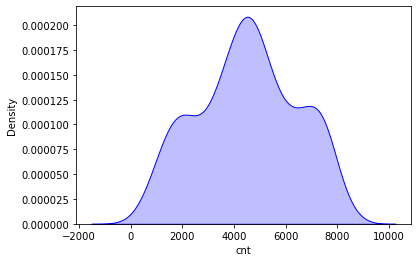

In [186]:
sns.distplot(
    df_bike.cnt, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

print(stats.shapiro(df_bike["cnt"])) # EL p-value< 0.05 Quiere decir que la distribución es normal

### Variables predictoras CATEGORICAS - GRAFICO

    Estas son nuestras variables categoricas

In [187]:
categoricas = df_bike.select_dtypes(include='object')
categoricas.head(1)

,temp_interval,hum_interval,wind_interval,wind_num_encoding
0,low,very_high,low,1


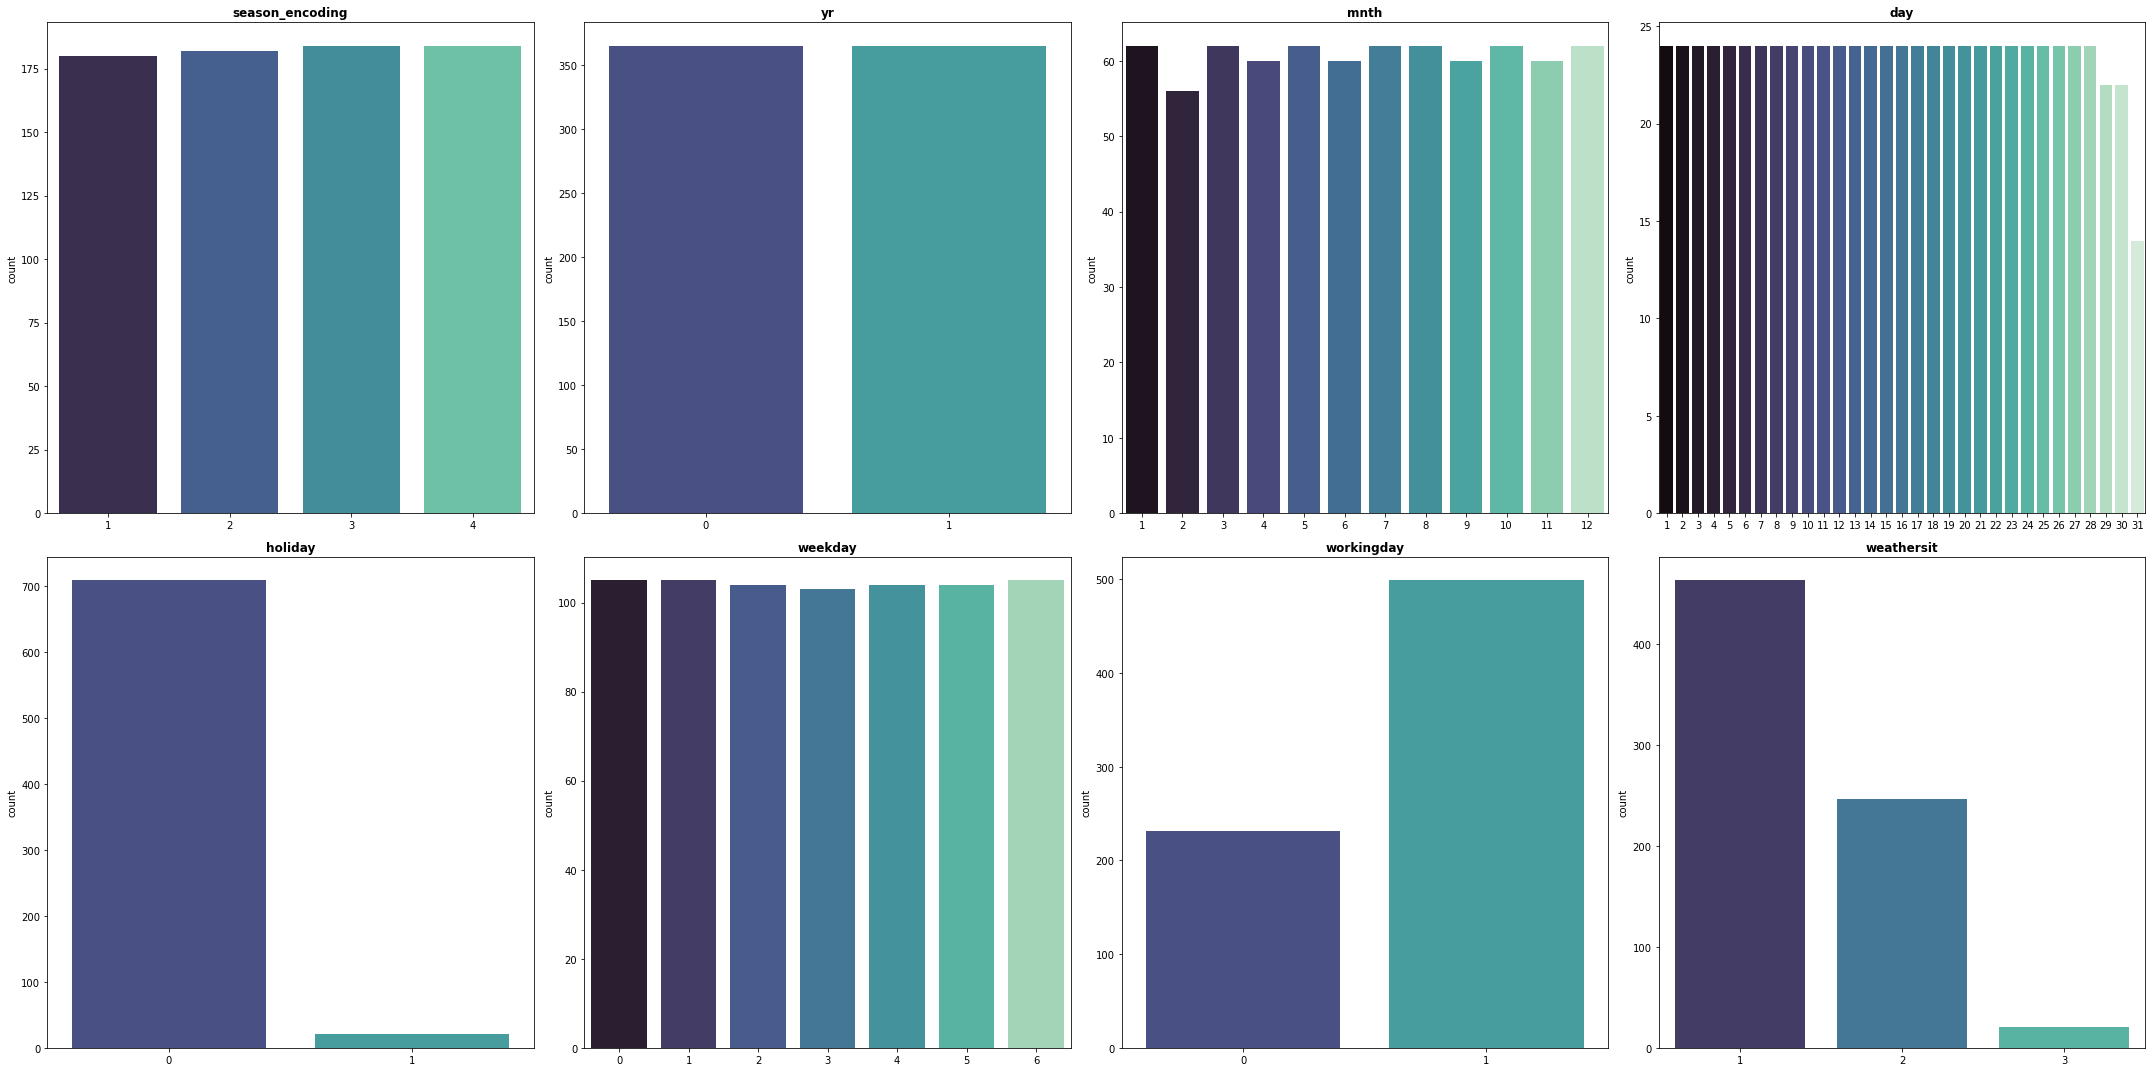

In [188]:
# Gráfico de relación entre variables predictoras y la variable a predecir CATEGORICAS
# ===================================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (30, 15))

axes = axes.flat

columnas_object = df.select_dtypes(include = "object").columns

for i, colum in enumerate(columnas_object):
    sns.countplot(df[colum], ax=axes[i], palette="mako")
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
fig.tight_layout();



### Variables predictoras NUMERICAS - GRAFICO

    Estas son nuestras variables numéricas

In [189]:
numericas = df.select_dtypes(include = np.number)
numericas.head(1)

,cnt,temp,hum,windspeed
0,985,14.1,80.6,10.749882


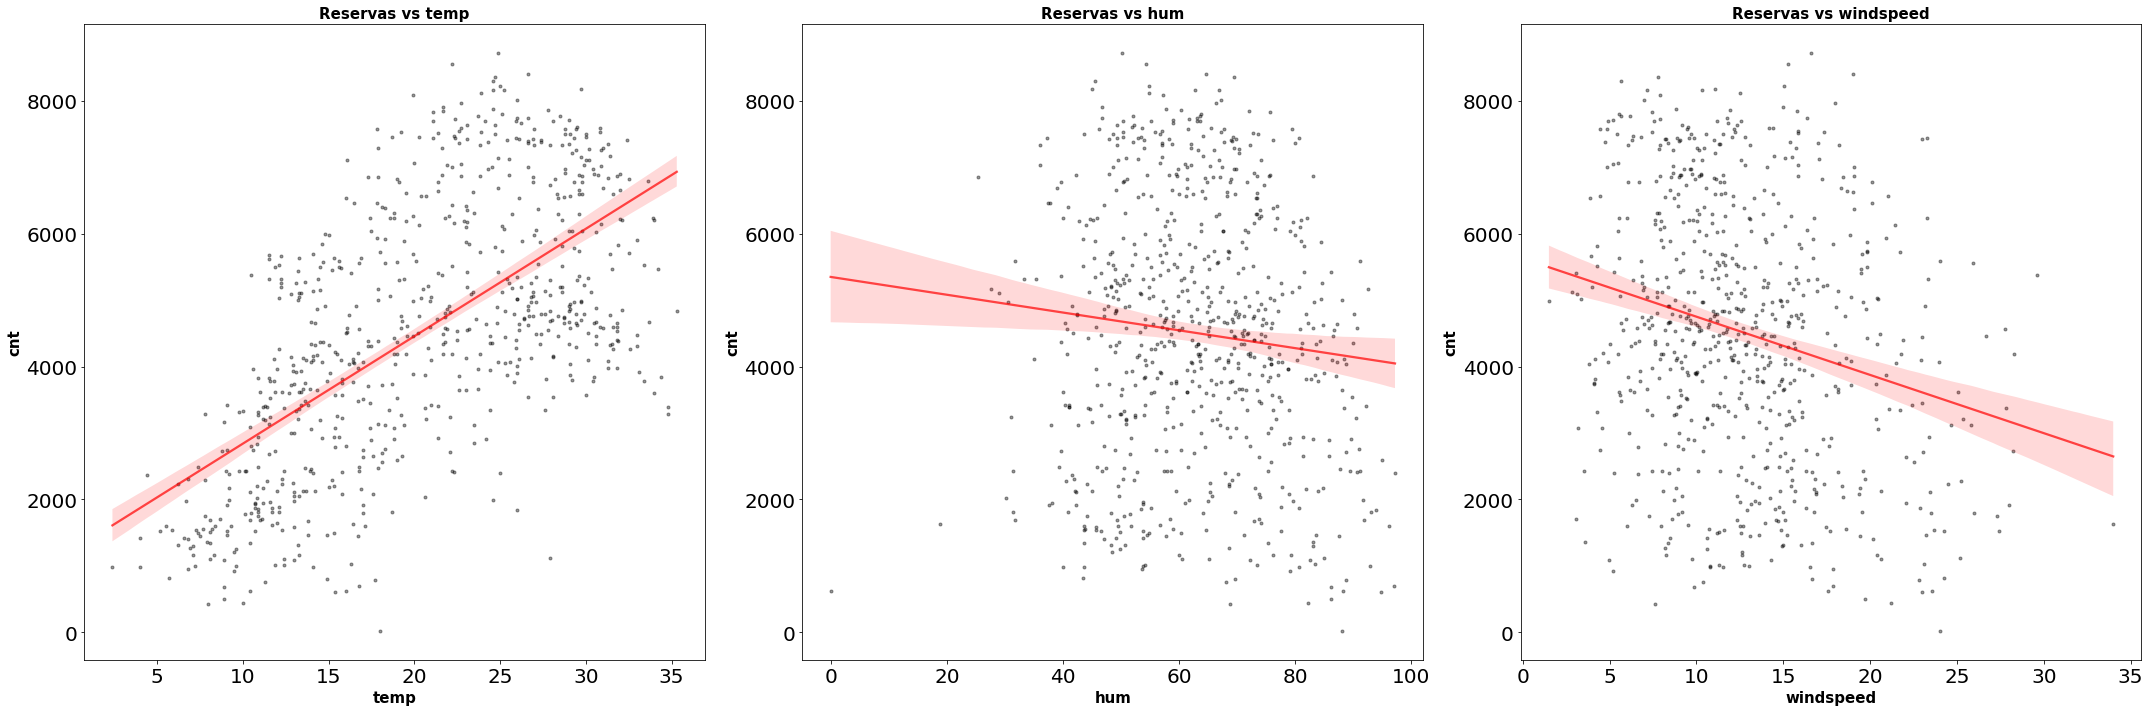

In [190]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("cnt") # excluimos nuestra variable respuesta. (No la necesitamos ahora

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["cnt"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Reservas vs {colum}", fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum,  fontsize = 15, fontweight = "bold")
    axes[i].set_ylabel("cnt", fontsize = 15, fontweight = "bold")
    
fig.tight_layout();

### Vamos a comprobar la relación que hay entre numericas

In [191]:
numericas2 = df.select_dtypes(include = np.number).drop("cnt", axis = 1)

    COVARIANZA
    ¿Ambas variables aumentan o disminuyen en la misma dirección o cuando una aumenta la otra disminuye?
        S> 0 COVARIANZA POSITIVA : Todos aumentan misma dirección ( a grandes valores de X, grandes valores de Y)
        S = 0 NO HAY RELACIÓN LINEAL
        S< 0 COVARIANZA NEGATIVA: Aumenta una y disminuye la otra (a grandes valores de X , pequeños valores de Y)

In [192]:
numericas2.cov() # vamos a ver si existe colinealidad entre mas medias de las variables predictoras

,temp,hum,windspeed
temp,56.350559,13.757125,-6.176868
hum,13.757125,202.717828,-18.389602
windspeed,-6.176868,-18.389602,26.996761


    CORRELACIÓN
        Vamos a ver la correlación entre las variables predictoras y que relación tienen tb con la respuesta.
        intervalo [-1 y 1]
	    r= 1 corr perfecta positiva (aumenta una , la otra tb aumenta)
	    r =0 no hay correlación
 	    r= -1 corr perfecta negativa (una aumenta y la otra disminuye)

In [193]:
numericas.corr()  # Pearson Correlation Coefficient

,cnt,temp,hum,windspeed
cnt,1.000000,0.627003,-0.098502,-0.235132
temp,0.627003,1.000000,0.128716,-0.158367
hum,-0.098502,0.128716,1.000000,-0.248582
windspeed,-0.235132,-0.158367,-0.248582,1.000000


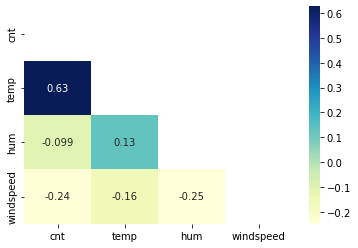

In [194]:
mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool))
sns.heatmap(numericas.corr(), 
           cmap = "YlGnBu", 
           annot = True, 
           mask =mask);


In [195]:
def detectar_outliers(lista_columnas, dataframe): 
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    return dicc_indices 

In [196]:
lista_columnas = list(numericas.columns)
lista_columnas

['cnt', 'temp', 'hum', 'windspeed']

     Son pocos Outliers que no influyen en demasiado lo cambiamos por la mediana

In [197]:
ind = detectar_outliers(lista_columnas, df)
print(ind)

{'hum': [49, 68], 'windspeed': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720]}


In [198]:
for k, v in ind.items():
    mediana = df[k].median() 
    for i in v: 
        df.loc[i,k] = mediana

# Comprobación de las asunciones - Las variables predictoras deben cumplir: Homocedasteidad, Independencia 

### ASUNCIÓN DE NORMALIDAD  

    Ya la hemos comprobado y nuestros datos son normales.

- Visualmente
- Test de Shapiro


| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

In [199]:
stats.shapiro(df["cnt"]) # El p-value< 0.05 Quiere decir que la distribución es normal

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

### ASUNCIÓN DE HOMOCEDASTICIDAD (Levene)

Las varianzas no difieren entre las distintas categorías de nuestros datos


| Test Levene  |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

    - Variables Categoricas -

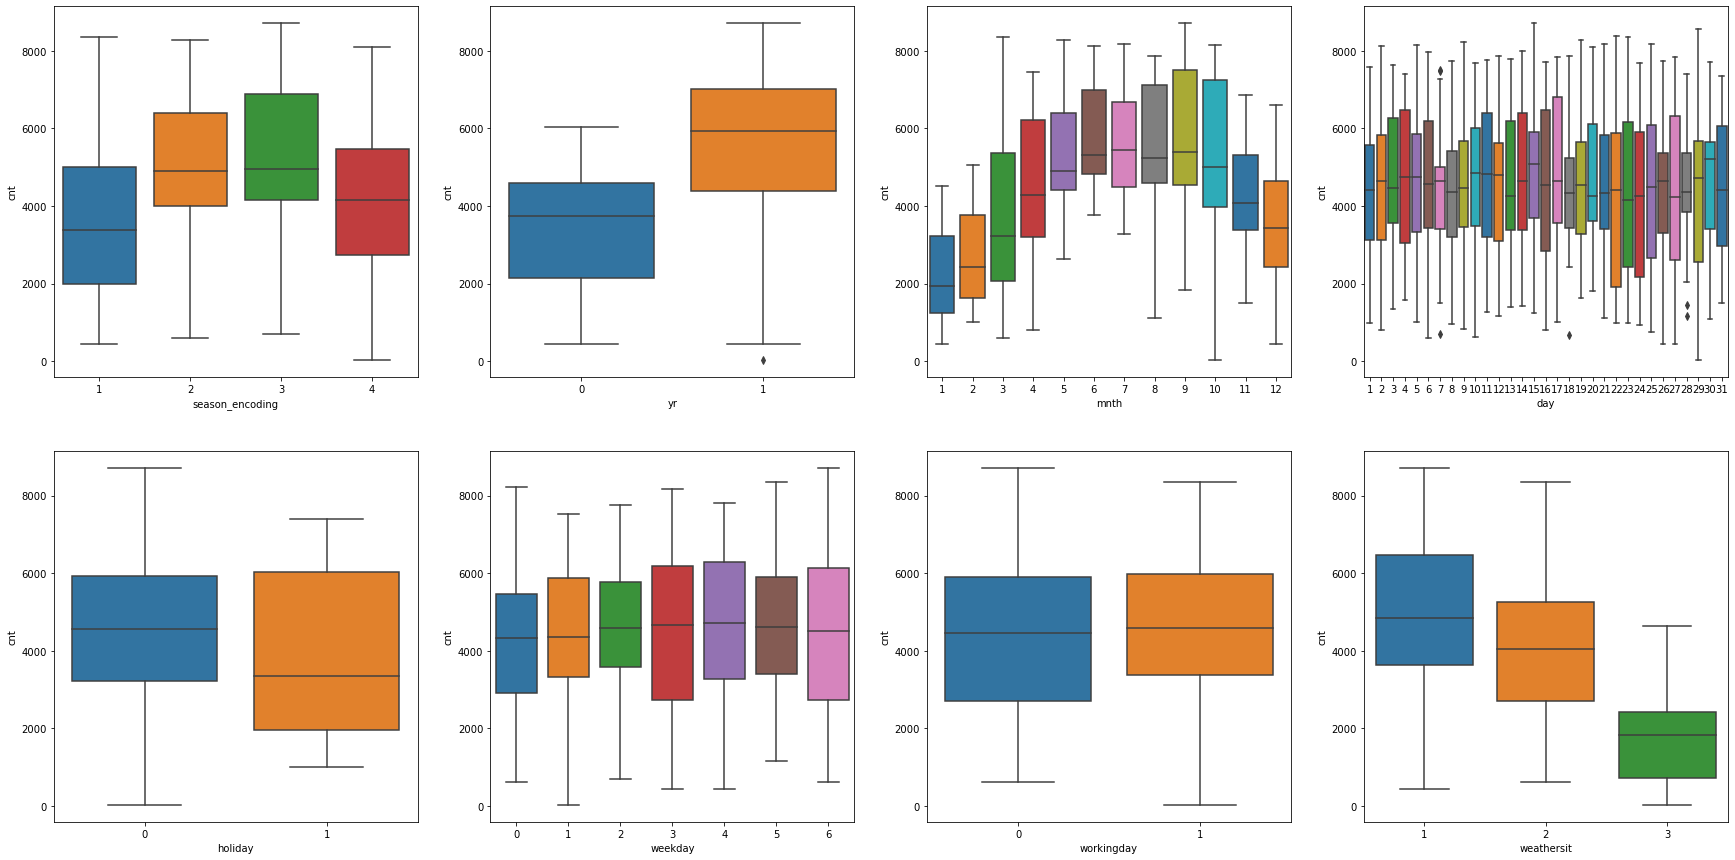

In [200]:
fig, axes = plt.subplots(nrows = 2, ncols = 4 ,figsize = (30, 15))

axes = axes.flat

colum_cat = df.select_dtypes(include = ['object']).columns

for i, col in enumerate(colum_cat):
    sns.boxplot(
        x = col,
        y = 'cnt',
        data = df,
        palette = 'tab10',
        ax = axes[i]

    )

                                                        --TEST LEVENE PARA CADA VARIABLE CATEGORICA PREDICTORA--

In [201]:
#Para desglosar cada una de las columnas, hacemos test de levene a cada una
def datos_test_levene (columna, df):
    valores = df[columna].unique()
    d = {}

    for x in valores:
        d['{0}'.format(x)] = df[df[columna] == x]['cnt']
    return d

In [203]:
# 8 variables categoricas predictoras
season = datos_test_levene('season_encoding', df)
year = datos_test_levene('yr', df)
month = sexo = datos_test_levene('mnth', df)
day = sexo = datos_test_levene('day', df)
holiday = sexo = datos_test_levene('holiday', df)
weekday = sexo = datos_test_levene('weekday', df)
workingday = sexo = datos_test_levene('workingday', df)
weathersit = sexo = datos_test_levene('weathersit', df)

                                                                        --NO CUMPLEN : "YEAR" , "MONTH" , "WORKINGDAY"--

In [206]:
levene_temp_interval = stats.levene(year['0'], year['1'], center='median')
levene_temp_interval # NO CUMPLE

LeveneResult(statistic=13.553593496753745, pvalue=0.0002489869491449798)

In [208]:
levene_temp_interval = stats.levene(month['1'], month['2'],month['3'],month['4'],month['5'],month['6'],month['1'],month['7'],month['1'],month['8'],month['9'],month['10'],month['11'],month['12'], center='median')
levene_temp_interval # NO CUMPLE

LeveneResult(statistic=5.787944098760116, pvalue=2.73789175494516e-10)

In [214]:
levene_temp_interval = stats.levene(workingday['0'], workingday['1'], center='median')
levene_temp_interval # NO CUMPLE

LeveneResult(statistic=4.460702577469021, pvalue=0.03502326959654844)

                                                         --SI CUMPLEN : "SEASON", "DAY", "HOLIDAY" , "WEEKDAY" , "WEATHERSIT"--

In [205]:
levene_season = stats.levene(season['1'], season['2'], season['3'], season['4'], center='median')
levene_season # SI CUMPLE

LeveneResult(statistic=1.7590626071065214, pvalue=0.15360584747469838)

In [209]:
levene_temp_interval = stats.levene(day['1'], day['2'],day['3'],day['4'],day['5'],day['6'],day['1'],day['7'],day['1'],day['8'],day['9'],day['10'],day['11'],day['12'],
 day['13'], day['14'],day['15'],day['16'],day['17'],day['18'],day['19'],day['20'],day['21'],day['22'],day['23'],day['24'],day['25'],day['26'],
 day['27'], day['28'],day['29'],day['30'],day['31'],center='median')
levene_temp_interval # SI CUMPLE

LeveneResult(statistic=0.5456780499569595, pvalue=0.9815493458112784)

In [210]:
levene_temp_interval = stats.levene(holiday['0'], holiday['1'], center='median')
levene_temp_interval # SI CUMPLE

LeveneResult(statistic=0.7261499110317795, pvalue=0.39441424379573353)

In [213]:
levene_temp_interval = stats.levene(weekday['0'], weekday['1'],weekday['2'],weekday['3'],weekday['4'],weekday['5'],weekday['6'], center='median')
levene_temp_interval # SI CUMPLE

LeveneResult(statistic=1.496581827336433, pvalue=0.17647662349169893)

In [215]:
levene_temp_interval = stats.levene(weathersit['1'], weathersit['2'], weathersit['3'],center='median')
levene_temp_interval # SI CUMPLE

LeveneResult(statistic=2.981948873358019, pvalue=0.05131438057388725)

    Numéricas

In [218]:

# creamos un diccionario para almacenar los resultados de los test
resultados = {}

# seleccionamos solo las columnas numéricas y eliminamos la columna de precio
numericas_col = df.select_dtypes(include = np.number).drop("cnt", axis = 1).columns

#iteremos por la lista de las columnas numéricas
for col in numericas_col:
    # calculamos el p-valor de test
    statistic, p_val = levene(df[col], df.cnt, center='median')
    # lo almacenamos en el charges
    resultados[col] = p_val

                    --  SI CUMPLEN TODAS --

In [219]:
resultados 

{'temp': 2.483823693494982e-220,
 'hum': 2.4852444623529654e-219,
 'windspeed': 6.996761844872213e-221}

## Asunción independencia (Chi-Cuadrado)


| Test Independencia |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

In [222]:
columnas = df.columns

In [223]:
combinaciones = list(itertools.combinations(columnas, 2))
combinaciones

[('cnt', 'season_encoding'),
 ('cnt', 'yr'),
 ('cnt', 'mnth'),
 ('cnt', 'day'),
 ('cnt', 'holiday'),
 ('cnt', 'weekday'),
 ('cnt', 'workingday'),
 ('cnt', 'weathersit'),
 ('cnt', 'temp'),
 ('cnt', 'hum'),
 ('cnt', 'windspeed'),
 ('season_encoding', 'yr'),
 ('season_encoding', 'mnth'),
 ('season_encoding', 'day'),
 ('season_encoding', 'holiday'),
 ('season_encoding', 'weekday'),
 ('season_encoding', 'workingday'),
 ('season_encoding', 'weathersit'),
 ('season_encoding', 'temp'),
 ('season_encoding', 'hum'),
 ('season_encoding', 'windspeed'),
 ('yr', 'mnth'),
 ('yr', 'day'),
 ('yr', 'holiday'),
 ('yr', 'weekday'),
 ('yr', 'workingday'),
 ('yr', 'weathersit'),
 ('yr', 'temp'),
 ('yr', 'hum'),
 ('yr', 'windspeed'),
 ('mnth', 'day'),
 ('mnth', 'holiday'),
 ('mnth', 'weekday'),
 ('mnth', 'workingday'),
 ('mnth', 'weathersit'),
 ('mnth', 'temp'),
 ('mnth', 'hum'),
 ('mnth', 'windspeed'),
 ('day', 'holiday'),
 ('day', 'weekday'),
 ('day', 'workingday'),
 ('day', 'weathersit'),
 ('day', 'temp')

    Test Chi Cuadrado
    Kramer: 
    de 0-0,1: no hay independencia
    de 0,1 - 0,3 independencia baja
    0,3 a 0,5 independencia moderada
    0,5+ independencia alta


In [224]:
for par in combinaciones:
    crosstab, test_results, expected = rp.crosstab(df[par[0]], df[par[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    print("---------------------------------", par[0], par[1], "---------------------------------")
    print(test_results)

--------------------------------- cnt season_encoding ---------------------------------
                   Chi-square test    results
0  Pearson Chi-square ( 2082.0) =   2089.9375
1                       p-value =      0.4470
2                    Cramer's V =      0.9769
--------------------------------- cnt yr ---------------------------------
                  Chi-square test   results
0  Pearson Chi-square ( 694.0) =   706.0000
1                      p-value =     0.3676
2                   Cramer's V =     0.9834
--------------------------------- cnt mnth ---------------------------------
                   Chi-square test    results
0  Pearson Chi-square ( 7634.0) =   7636.3074
1                       p-value =      0.4904
2                    Cramer's V =      0.9752
--------------------------------- cnt day ---------------------------------
                    Chi-square test     results
0  Pearson Chi-square ( 20820.0) =   20849.4399
1                        p-value =       0.4

# ANOVA

    Ya podemos pasar a la ANOVA después de comprobar si las variables predictoras cumplen las asunciones

In [225]:
df.columns

Index(['cnt', 'season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed'],
      dtype='object')

    Debo estandarizar los datos de las numericas??

In [226]:
lm = ols('cnt ~ season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp + hum +  windspeed' , data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
season_encoding,3.0,2.965983e+08,9.886610e+07,157.963531,1.775265e-77
yr,1.0,8.869095e+08,8.869095e+08,1417.061602,1.160184e-167
mnth,11.0,7.803896e+08,7.094451e+07,113.351749,5.236439e-145
day,30.0,6.263900e+07,2.087967e+06,3.336053,1.043850e-08
holiday,1.0,8.356054e+06,8.356054e+06,13.350904,2.784305e-04
weekday,6.0,1.555021e+07,2.591702e+06,4.140898,4.279602e-04
workingday,1.0,1.100045e+06,1.100045e+06,1.757599,1.853747e-01
weathersit,2.0,1.740145e+08,8.700727e+07,139.016064,2.992330e-51
temp,1.0,5.589275e+07,5.589275e+07,89.302758,5.514519e-20
hum,1.0,6.484288e+06,6.484288e+06,10.360286,1.349474e-03


In [227]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     64.80
Date:                Fri, 10 Jun 2022   Prob (F-statistic):          1.44e-234
Time:                        16:00:02   Log-Likelihood:                -5877.2
No. Observations:                 730   AIC:                         1.187e+04
Df Residuals:                     672   BIC:                         1.214e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1053.5278    302.796      3.479      0.001     458.987    1648.069
season_encoding[T.2]  -308.4979    170.782     -1.806      0.071    -643.829      26.833
season_encoding[T.3]   -22.0288    174.971     -0.126      0.900    -365.584     321.526
season_encoding[T.4] -1075.2111    172.586     -6.230      0.000   -1414.084    -736.338
yr[T.1]               2017.2122     60.211     33.503      0.000    1898.988    2135.436
mnth[T.2]              134.9292    149.086      0.905      0.366    -157.802     427.660
mnth[T.3]              846.6635    157.602      5.372      0.000     537.212    1156.115
mnth[T.4]             1531.2036    204.252      7.497      0.000    1130.155    1932.252
mnth[T.5]             1818.9226    231.488      7.858      0.000    1364.395    2273.450
mnth[T.6]             1575.1935    263.376      5.981      0.000    1058.054    2092.333
mnth[T.7]              886.0844    305.986      2.896      0.004     285.281    1486.888
mnth[T.8]             1269.6197    287.765      4.412      0.000     704.594    1834.646
mnth[T.9]             2050.9704    256.539      7.995      0.000    1547.256    2554.685
mnth[T.10]            2746.0005    215.957     12.715      0.000    2321.969    3170.032
mnth[T.11]            2141.0754    191.897     11.157      0.000    1764.285    2517.866
mnth[T.12]            1589.8065    185.593      8.566      0.000    1225.394    1954.219
day[T.2]               208.9083    229.203      0.911      0.362    -241.132     658.948
day[T.3]               331.1072    229.283      1.444      0.149    -119.090     781.304
day[T.4]               722.6532    285.970      2.527      0.012     161.151    1284.156
day[T.5]               566.4052    285.787      1.982      0.048       5.263    1127.547
day[T.6]               695.4048    286.340      2.429      0.015     133.177    1257.633
day[T.7]               156.1130    288.413      0.541      0.588    -410.186     722.412
day[T.8]               102.1095    288.140      0.354      0.723    -463.654     667.873
day[T.9]               271.2148    286.920      0.945      0.345    -292.153     834.583
day[T.10]             1440.9054    286.833      5.023      0.000     877.708    2004.103
day[T.11]             1533.7674    286.161      5.360      0.000     971.889    2095.645
day[T.12]             1355.8208    287.312      4.719      0.000     791.684    1919.957
day[T.13]              667.5143    252.873      2.640      0.008     170.997    1164.031
day[T.14]              599.4625    252.200      2.377      0.018     104.268    1094.657
day[T.15]              858.8688    252.448      3.402      0.001     363.187    1354.551
day[T.16]              806.4521    253.183      3.185      0.002     309.328    1303.576
day[T.17]              975.6708    252.563      3.863    

# VIF - REpasar no me sale

In [230]:
def get_VIF(dataframe, target):
        X = add_constant(dataframe.loc[:, dataframe.columns != target])
        seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,).sort_values(ascending= False)
        return seriesObject

In [ ]:
get_VIF(df, 'cnt')

# Regresion Lineal

    Prueba con los datos tal cualen DF

In [245]:
df.head(2)

,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,985,1,0,1,1,0,6,0,2,14.1,80.6,10.749882
1,801,1,0,1,2,0,0,0,2,14.9,69.6,16.652113


In [232]:
# lo primero que hacemos es definir cual es nuestra variable Y y nuestras variables X
X = df.drop('cnt', axis =1)
y = df['cnt']

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

LinearRegression()

In [240]:
def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df
    

In [243]:
results = metricas(y_test, y_train, y_pred_test, y_pred_train)
results.style.background_gradient(cmap='coolwarm')
results

,MAE,MSE,RMSE,R2,set
0,612.080112,651204.915388,806.972686,0.809747,test
1,714.125564,897542.027626,947.386947,0.764776,train


    Prueba Estandarizando las variables numéricas

In [247]:
df_standardized = df.copy()

In [248]:
numericas2 = df_standardized.select_dtypes(include = np.number)

In [249]:
st = StandardScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(numericas2))
x_tranformadas.columns = numericas2.columns
df[x_tranformadas.columns] = x_tranformadas
df.head()

,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,-1.820972,1,0,1,1,0,6,0,2,-0.829070,1.253554,-0.387833
1,-1.916078,1,0,1,2,0,0,0,2,-0.722425,0.480439,0.748899
2,-1.632827,1,0,1,3,0,1,1,1,-1.628904,-1.339897,0.745931
3,-1.522732,2,0,1,4,0,2,1,1,-1.615573,-0.264563,-0.389769
4,-1.503090,2,0,1,5,0,3,1,1,-1.468937,-1.339897,-0.046477


In [250]:
x2 = df_standardized.drop('cnt', axis =1)
y2 = df_standardized['cnt']

In [251]:
X_train, X_test, y_train, y_test = train_test_split(x2, y2, train_size   = 0.8, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [252]:
def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

In [253]:
results = metricas(y_test, y_train, y_pred_test, y_pred_train)
results.style.background_gradient(cmap='coolwarm')
results

,MAE,MSE,RMSE,R2,set
0,0.310200,0.162431,0.403027,0.822376,test
1,0.367896,0.238463,0.488326,0.766080,train


----

# FIN

- Habria que revisar Anova y VIF para determinar si merece la pena quitar una variable o no
- Que nos cuentan los datos, resumen en ANOVA y VIF
- VIF no me ha funcionado (hay que nvestigar por que)